# Importing D-Wave Libraries

# Finding Optimal Distribution Center Locations(Amazon Prime Air)

Here we adapt the problem UD-MIS problem to the problem of determining distribution centers for Amazon Prime Air drones to deliver their goods from.  The unit disk represents the range that a drone can fly out to deliver a package and back without having to recharge.  Ideally, we want to maximize the coverage of these distribution centers by making sure they are not overlapping.

Considering the possibility of overlapping, a cost benefit analysis has to be done comparing the benefit of access to new customers(in nonoverlapping areas) vs the cost of building and maintaining that additional center.

In the code below we frame the problem as a quadratic unconstrained optimization problem providing a benefit for the most distribution centers available as the Q[(i,i)] term.  We provide a stronger constraint for off diagonal terms in this matrix representing a penalty for wasted coverage if two distribution centers are too close together and overlapping.  The edges are determined by the range of nearby nodes so as to limit the optimization problem to only looking at these, and not every permutation of node pairs.

In [3]:
import neal
import dwave_networkx as dnx
from dwave.system import DWaveSampler, EmbeddingComposite
import dimod
from dwave.system import LeapHybridSampler

import networkx as nx
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import random as rand
import time
import numpy as np

%matplotlib inline

# Building our QUBO Problem, and QPU functions

In [4]:
def get_qubo(N,edge_nodes): # input a set of
    """Returns a dictionary representing a QUBO.
    Args:
        S(list of tuples): the coordinates of each node
    """
    
    Q = {}

    # Build QUBO 
    #Bonus for sites occupied to meet maximum condition
    
    for i in range(N):
        Q[(i,i)] = -1
 
    
    #Edge Constraints, # off diagonals
    for i in range(len(edge_nodes)):
        Q[(edge_nodes[i][0],edge_nodes[i][1])] = 3
    
    return Q

    
def run(Q, sampler, numruns = 10):
    """Runs the QUBO problem Q on the sampler provided.
    Args:
        Q(dict): a representation of a QUBO
        sampler(dimod.Sampler): a sampler that uses the QPU
    """   
    

    sample_set = sampler.sample_qubo(Q, num_reads=numruns)
    
    return sample_set



# Building our problem graph

In [5]:


# Create Nodes
nodes = [(1.19, 4.25),
(2.71, 3.48),
(1.19, 3.51),
(2, 3.38),
(1.12, 2.86),
(1.70, 2.42),
(2.36, 2.54),
(1.52, 1.48),
(2.15, 1.54),
(2.14, 1.87),
(1.72, 0.86),
(2.29, 0.87)]
edge_nodes =[]



def graphN(nodes):
    # Create empty graph
    G = nx.Graph()

    # Generate edges if they are close  within a distance of 1
    edge_nodes =[] #nodes numbers for generating objective function inside Qubo function Q
    edges = [] #coordinates for graph
    for i in range(len(nodes)-1):
        for j in range(i+1,len(nodes)):
            xi = nodes[i][0]
            xj = nodes[j][0]
            yi = nodes[i][1]
            yj = nodes[j][1]
            dij = ((xi-xj)**2 +(yi-yj)**2)**(1/2)
            if dij <= 1:
                edge =(nodes[i],nodes[j])
                edge_indices = (i,j)
                edge_nodes.append(edge_indices)
                edges.append(edge)

    G.add_edges_from(edges)
    return G, edge_nodes, edges

G, edge_nodes,edges = graphN(nodes)

# Running problem on Dwave qpu

In [93]:
Q = get_qubo(len(nodes),edge_nodes)

#Set Sampler             
sampler = EmbeddingComposite(DWaveSampler(profile='CDL'))
sample_set = run(Q, sampler)
    
print(sample_set)    

   0  1  2  3  4  5  6  7  8  9 10 11 energy num_oc. chain_.
0  1  0  0  1  1  0  0  0  0  1  0  1   -5.0       1     0.0
1  1  1  0  0  1  0  1  0  0  0  1  0   -5.0       2     0.0
2  1  1  0  0  1  0  0  0  0  1  1  0   -5.0       2     0.0
3  1  1  0  0  1  0  1  0  1  0  0  0   -5.0       2     0.0
4  1  0  0  1  1  0  0  0  0  1  1  0   -5.0       1     0.0
5  0  1  0  0  1  0  1  1  0  0  0  0   -4.0       1     0.0
6  1  0  0  0  1  0  0  0  0  1  0  1   -4.0       1     0.0
['BINARY', 7 rows, 10 samples, 12 variables]


In [94]:
sample = list(sample_set.record[0][0])

print('Maximum independent set found is' ,sample)

Maximum independent set found is [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]


In [95]:
# Visualize the results

G, edge_nodes,edges = graphN(nodes)

def graph_visualize(sample,nodes,G,title):
    fig, ax = plt.subplots(figsize=(8,8))
    sample_nodes = []
    for i in range(len(sample)):
        if sample[i] == 1:
            sample_nodes.append(nodes[i])   
    notsample = list(set(G.nodes()) - set(sample_nodes))
    color_map = []
    for node in range(len(sample)):
        if sample[node] ==1:
            color_map.append('red')
        else: 
            color_map.append('blue')     

    original_name = "antenna_plot_original.png"
    pos ={}
    for i in range(len(nodes)): # add positions
        pos[nodes[i]]=nodes[i]
    
    frosting = []
    for i in range(len(sample)):
        cake = (nodes[i],color_map[i])
        frosting.append(cake)
    
    #print(frosting)
    for x,y in nodes:   ## add radius
        circle = plt.Circle((x,y), 0.5, color='gray', alpha=0.1)
        ax.add_patch(circle)
        
  
    ax.set_title(title)
    nx.draw_networkx(G, pos,node_color=color_map,with_labels=False)
    ax.axis('equal')
    #plt.savefig(original_name, bbox_inches='tight')
    #plt.show()
    return

graph_visualize(sample,nodes,G,'D-Wave QPU')


# Simulated Annealing

In [6]:
Q = get_qubo(len(nodes),edge_nodes)
numruns = 2000

#Set Sampler             
sampler = neal.SimulatedAnnealingSampler()
sample_set = run(Q, sampler,numruns)


In [7]:
sample = list(sample_set.record[0][0])
E_best = list(sample_set.record[0])[1]
print('E_best = ',E_best)
print('Best sample = ',sample)


E_best =  -5.0
Best sample =  [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]


In [86]:
# Visualize the results

graph_visualize(sample,nodes,G,'D-wave neal Simulated Annealing Package')

[((1.19, 4.25), 'red'), ((2.71, 3.48), 'blue'), ((1.19, 3.51), 'blue'), ((2, 3.38), 'red'), ((1.12, 2.86), 'red'), ((1.7, 2.42), 'blue'), ((2.36, 2.54), 'blue'), ((1.52, 1.48), 'blue'), ((2.15, 1.54), 'blue'), ((2.14, 1.87), 'red'), ((1.72, 0.86), 'blue'), ((2.29, 0.87), 'red')]


# D-Wave Leap Hybrid Solver

In [108]:
Q = get_qubo(len(nodes),edge_nodes)

#Set Sampler             
sampler = LeapHybridSampler(profile='CDL',time_limit=10)
sample_set = sampler.sample_qubo(Q)


In [48]:
sample = list(sample_set.record[0][0])
E_best = list(sample_set.record[0])[1]
print('E_best = ',E_best)
print('Best sample = ',sample)

E_best =  -5.0
Best sample =  [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]


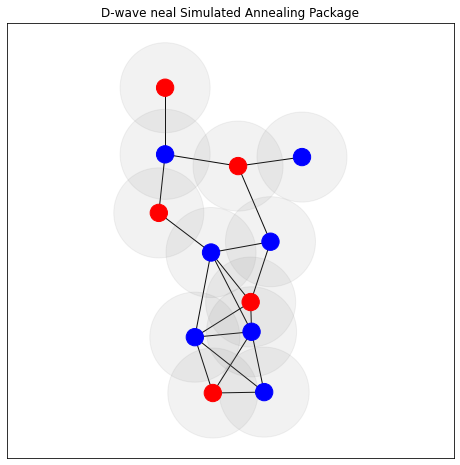

In [49]:
# Visualize the results
graph_visualize(sample,nodes,G,'D-wave Hybrid Solver')

# Generating best Calculation time vs number of nodes in the graph and computation time


In [9]:
# Generate calculation time and best energy for each N
N = 40
num_runs = 5

def time_benchmark_vs_N(N,num_runs,sampler,hybrid = 0):
    
    # Generating N
    Ns=[]
    Es = []
    del_times = []

    def gen_node(N):    
   
        rng = N/4
        nodes = []
        for i in range(N):
            pcoord = (rand.uniform(1,rng),rand.uniform(1,rng))
            nodes.append(pcoord)

        return nodes    
    
    
    def run_algo(N,num_runs,hybrid):
            num_runs = 10
            start = time.time()   
            nodes = gen_node(N)   # output node coords
            G, edge_nodes,edges = graphN(nodes)   # create problem graph for N

            #Generate qubo
            Q = get_qubo(len(nodes),edge_nodes)
            if hybrid == 0:
                sample_set = run(Q, sampler,num_runs)
            else:
                sample_set = sampler.sample_qubo(Q)
            sample = list(sample_set.record[0][0])
            E_best = list(sample_set.record[0])[1]
            Es.append(E_best)

            end = time.time()                              

            del_t = end  - start
            return del_t, E_best
        
    #Loop over N's
    for i in range(1,N+1):
                                  
        Ns.append(i)
        
        
        del_t, E_best = run_algo(i,num_runs,hybrid)
        del_times.append(del_t)
    return Ns,Es,del_times


# Dwave simulated annealer
sampler = neal.SimulatedAnnealingSampler()
Ns,Es,del_times = time_benchmark_vs_N(N,num_runs,sampler)
#Dwave QPU
# sampler = EmbeddingComposite(DWaveSampler(profile='CDL'))
# QNs,QEs,Qdel_times = time_benchmark_vs_N(N,num_runs,sampler)

#Dwave Hybrid Solver
# sampler = LeapHybridSampler(profile='CDL',time_limit=10)
# HNs,HEs,Hdel_times = time_benchmark_vs_N(N,num_runs,sampler,hybrid = 1)

# Calculation time Benchmark

For networks of 40 nodes or less we see that the classical simulated annealer has the best performance follow by D-Wave QPU.  The D-Wave hybrid solver lags behind possibly to some internal overhead.  It is unclear from this study whether it pulls ahead for larger N networks.

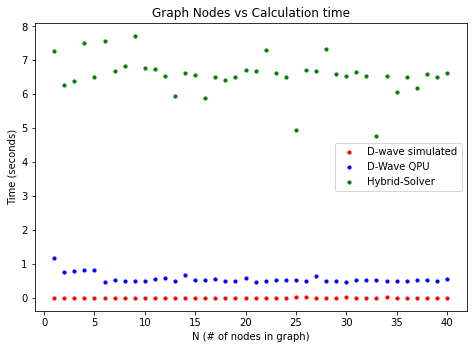

In [116]:
#Generate Graph
def plot_time_benchmark(Es,Ns,del_times,QEs,QNs,Qdel_times,HEs,HNs,Hdel_times):
    

    calc_times = del_times
    Ns = Ns
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(Ns, del_times, color='r',s = 10,label = 'D-wave simulated')
    ax.scatter(QNs, Qdel_times, color='b',s = 10,label = 'D-Wave QPU')
    ax.scatter(HNs, Hdel_times, color='g',s = 10,label = 'Hybrid-Solver')
    #m, b = np.polyfit(Ns, del_times, 1)     #bestfit
    #plt.plot(Ns, m*Ns+b)
    
    #ax.scatter(grades_range, boys_grades, color='b')     other plots
    ax.set_xlabel('N (# of nodes in graph)')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Graph Nodes vs Calculation time')
    plt.legend()
    plt.show()
    return

plot_time_benchmark(Es,Ns,del_times,QEs,QNs,Qdel_times,HEs,HNs,Hdel_times)